In [255]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kaggle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, MultiLabelBinarizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import NearMiss
from numpy import where
import pickle



from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from dask.distributed import Client

My project is focused on predicitng wether an item will be purchased or removed from the cart on an ecomemrce store. This will be used to help in marketing, sales. On the supply chain side it will also give more insights into how a product is viewed by customers and how much a brand/product should be stocked or not.

### Importing and preparing the data

In [256]:
#Convert csv to DataFrame
oct19 = pd.read_csv("../data/2019-Oct.csv")
nov19 = pd.read_csv("../data/2019-Nov.csv")
dec19 = pd.read_csv("../data/2019-Dec.csv")
jan20 = pd.read_csv("../data/2020-Jan.csv")
feb20 = pd.read_csv("../data/2020-Feb.csv")

In [257]:
print(oct19.shape)
print(nov19.shape)
print(dec19.shape)
print(jan20.shape)
print(feb20.shape)
print(oct19.shape[0]+nov19.shape[0]+dec19.shape[0]+jan20.shape[0]+feb20.shape[0])

(4102283, 9)
(4635837, 9)
(3533286, 9)
(4264752, 9)
(4156682, 9)
20692840


In [258]:
ecom_df = pd.concat([oct19, nov19, dec19, jan20, feb20], axis=0)
ecom_df.head()
print(ecom_df.shape)

(20692840, 9)


In [259]:
# Dropping columns here to save memory latter on
ecom_df = ecom_df[ecom_df.event_type != 'view']
ecom_df = ecom_df[ecom_df.event_type != 'cart']
print(ecom_df.shape)

(5266686, 9)


# Data Cleaning

### NAs and how to deal with them

In [260]:
#NAs in Brand
ecom_df.brand.fillna(value="unknown", axis=0, inplace=True)

In [261]:
#NAs in user_session 
ecom_df.dropna(inplace=True)

In [262]:
ecom_df.category_code.isna().sum()

0

In [263]:
ecom_df.category_code.value_counts()

appliances.environment.vacuum             16225
stationery.cartrige                       15751
apparel.glove                             15683
furniture.bathroom.bath                    4086
furniture.living_room.cabinet              2046
accessories.bag                             754
accessories.cosmetic_bag                    500
appliances.personal.hair_cutter             276
appliances.personal.massager                212
appliances.environment.air_conditioner      104
furniture.living_room.chair                  26
Name: category_code, dtype: int64

In [264]:
#Drop this column, as we will use category code instead
ecom_df.drop("category_id", axis=1, inplace = True)

In [265]:
#Get rid of negative prices
ecom_df = ecom_df[ecom_df['price']>= 0]

In [266]:
#Set target to binary
ecom_df.event_type = ecom_df["event_type"].replace({'purchase': 1, 'remove_from_cart': 0})

In [267]:
print(ecom_df.shape)

(55663, 8)


# Feature Engineering

purchase per session, group session, total of price added up for each purchase in session

### Time FE

In [268]:
ecom_df['event_time'] = pd.to_datetime(ecom_df['event_time'])

In [269]:
#needs checking
dr = pd.date_range(start='2019-10-01', end='2020-02-29')
df = pd.DataFrame()
df['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())
ecom_df['holiday'] = ecom_df['event_time'].isin(holidays)

ecom_df.sample(25)

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,holiday
977955,2019-11-07 23:08:52+00:00,0,6737,apparel.glove,unknown,5.24,555444394,d46a95bd-26c8-4c3d-8c71-c35afcc226e4,False
1494557,2019-12-12 08:09:16+00:00,0,5767494,stationery.cartrige,italwax,2.14,584227947,ad6c22fc-c426-48b2-ba40-64f9e4d90510,False
2570140,2020-02-18 11:41:34+00:00,1,5732039,furniture.bathroom.bath,domix,3.41,615365754,af533495-b99c-4daa-a38a-f031d186b4fe,False
3706753,2020-01-28 09:13:02+00:00,0,5921390,apparel.glove,unknown,0.00,516530435,c476e9ae-d6b9-4891-8ca9-ac1d5b6232d2,False
4039815,2020-01-30 10:53:46+00:00,1,5743974,stationery.cartrige,italwax,1.98,608100406,c285209d-ce26-4acb-9b45-82283287b1cb,False
1611213,2019-12-13 04:30:55+00:00,0,5911186,apparel.glove,dewal,1.87,434874566,e7f8ffdb-ed60-4fa0-8520-ca76d6ee1cda,False
97906,2020-01-02 08:30:04+00:00,1,5756537,apparel.glove,unknown,6.19,580189695,309455fa-1b30-419b-840c-68f4bc2bbc81,False
3973319,2019-11-27 13:55:18+00:00,0,5713296,appliances.personal.hair_cutter,unknown,55.56,577470002,e34a7154-5f42-4734-e51c-52f38fe86cca,False
1466806,2020-01-13 05:46:56+00:00,0,5856193,furniture.living_room.cabinet,runail,82.54,587631356,8a861009-0869-48ce-aff1-b23f55bce52e,False
2197045,2019-10-16 18:28:00+00:00,0,5856191,appliances.environment.vacuum,runail,24.44,560951002,cc50ba43-71b0-4648-9584-4c04f40f0ace,False


In [270]:
ecom_df['month'] = pd.DatetimeIndex(ecom_df['event_time']).month
ecom_df['2020'] = pd.DatetimeIndex(ecom_df['event_time']).year
ecom_df['hour'] = pd.DatetimeIndex(ecom_df['event_time']).hour
ecom_df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,holiday,month,2020,hour
264,2019-10-01 00:07:58+00:00,0,5767493,stationery.cartrige,italwax,2.14,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,False,10,2019,0
269,2019-10-01 00:08:03+00:00,0,5759489,stationery.cartrige,italwax,2.14,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,False,10,2019,0
274,2019-10-01 00:08:08+00:00,0,5657894,stationery.cartrige,unknown,2.06,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,False,10,2019,0
276,2019-10-01 00:08:10+00:00,0,24336,stationery.cartrige,depilflax,3.02,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,False,10,2019,0
278,2019-10-01 00:08:18+00:00,0,5775822,stationery.cartrige,italwax,2.14,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,False,10,2019,0


In [271]:
#convert year to binary
ecom_df['2020'] = ecom_df['2020'].replace({2019: 0, 2020: 1})

In [272]:
ecom_df['day'] = ecom_df['event_time'].dt.dayofweek
ecom_df['day'] = ecom_df['day'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

In [273]:
when_df = pd.DataFrame({'hour':range(1, 25)})
bins = [0,6,12,18,24]
labels = ['Night', 'Morning','Afternoon','Evening']
when_df['when'] = pd.cut(when_df['hour'], bins=bins, labels=labels, include_lowest=True)
#fix bellow
ecom_df = ecom_df.join(when_df['when'], on="hour")

In [274]:
ecom_df['month'] = ecom_df['month'].replace({1: 'January', 2: 'Febuary', 10: 'October', 11: 'November', 12: 'December'})

In [275]:
print(ecom_df.shape)

(55663, 14)


In [176]:
#ecom_df["current_session_clicks"] = ecom_df.groupby(['user_session'])['event_type'].cumsum()

In [177]:
#need to turn the features into numeric for bellow to work
#ecom_df["current_session_event_types"] = ecom_df.groupby(['user_session'])['event_type'].cumsum()

In [178]:
#ecom_df["session_cumulative_events"] = ecom_df.groupby(ecom_df.user_session)["event_type"].cumsum()
#ecom_df.head()

# Labeling

In [276]:
encoder = LabelBinarizer()
brand_labels = pd.DataFrame(encoder.fit_transform(ecom_df['brand']), columns=encoder.classes_, index=ecom_df.index)
brand_labels.head()

,babyliss,benovy,cutrin,depilflax,dewal,domix,emil,farmavita,farmona,gehwol,...,nitrimax,oniq,polarus,profepil,runail,shifei,shik,unknown,vosev,yoko
264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
276,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [277]:
encoder = LabelBinarizer()
productid_labels = pd.DataFrame(encoder.fit_transform(ecom_df['product_id']), columns=encoder.classes_, index=ecom_df.index)
productid_labels.head()

,4923,4962,4965,4986,5395,6736,6737,6817,8098,8372,...,5926444,5926445,5926580,5926583,5926585,5926586,5928359,5929649,5929650,5929651
264,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [278]:
ohe = OneHotEncoder(sparse=False, drop='first')
catco_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['category_code']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["category_code"]].columns))
catco_labels.head()

,category_code_accessories.cosmetic_bag,category_code_apparel.glove,category_code_appliances.environment.air_conditioner,category_code_appliances.environment.vacuum,category_code_appliances.personal.hair_cutter,category_code_appliances.personal.massager,category_code_furniture.bathroom.bath,category_code_furniture.living_room.cabinet,category_code_furniture.living_room.chair,category_code_stationery.cartrige
264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [279]:
ohe = OneHotEncoder(sparse=False, drop='first')
day_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['day']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["day"]].columns))
day_labels.head()

,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
264,0.0,0.0,0.0,0.0,1.0,0.0
269,0.0,0.0,0.0,0.0,1.0,0.0
274,0.0,0.0,0.0,0.0,1.0,0.0
276,0.0,0.0,0.0,0.0,1.0,0.0
278,0.0,0.0,0.0,0.0,1.0,0.0


In [280]:
ohe = OneHotEncoder(sparse=False, drop='first')
month_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['month']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["month"]].columns))
month_labels.head()

,month_Febuary,month_January,month_November,month_October
264,0.0,0.0,0.0,1.0
269,0.0,0.0,0.0,1.0
274,0.0,0.0,0.0,1.0
276,0.0,0.0,0.0,1.0
278,0.0,0.0,0.0,1.0


In [281]:
ohe = OneHotEncoder(sparse=False, drop='first')
when_labels = pd.DataFrame(ohe.fit_transform(ecom_df[['when']]), index=ecom_df.index, columns=ohe.get_feature_names(ecom_df[["when"]].columns))
when_labels.head()

,when_Evening,when_Morning,when_Night
264,0.0,0.0,1.0
269,0.0,0.0,1.0
274,0.0,0.0,1.0
276,0.0,0.0,1.0
278,0.0,0.0,1.0


In [282]:
print(ecom_df.shape)

(55663, 14)


In [283]:
#Join our Labeled Columns to our main DataFrame
#ecom_df = ecom_df.join(etype_labels)
ecom_df = ecom_df.join(brand_labels)
ecom_df = ecom_df.join(productid_labels)
ecom_df = ecom_df.join(catco_labels)
ecom_df = ecom_df.join(day_labels)
ecom_df = ecom_df.join(month_labels)
ecom_df = ecom_df.join(when_labels)                        
ecom_df.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,holiday,month,...,day_Thursday,day_Tuesday,day_Wednesday,month_Febuary,month_January,month_November,month_October,when_Evening,when_Morning,when_Night
66,2019-11-01 00:04:33+00:00,1,5766980,stationery.cartrige,italwax,1.98,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f,False,November,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
67,2019-11-01 00:04:33+00:00,1,5767494,stationery.cartrige,italwax,2.14,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f,False,November,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
68,2019-11-01 00:04:33+00:00,1,5775813,stationery.cartrige,italwax,1.98,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f,False,November,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
69,2019-11-01 00:04:33+00:00,1,5775814,stationery.cartrige,italwax,1.98,564451209,861ab2f1-b2e5-886f-a93b-5b067eff081f,False,November,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
264,2019-10-01 00:07:58+00:00,0,5767493,stationery.cartrige,italwax,2.14,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,False,October,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [188]:
print(ecom_df.shape)

(93421, 555)


# Preprocessing Data

### Train Test Split

In [284]:
X = ecom_df.drop(["month", "hour", "day", "when", "user_id", "product_id", "category_code", "event_time", "event_type", "brand", "user_session"], axis=1)
y = ecom_df.event_type

In [285]:
ecom_df.shape

(93421, 555)

In [286]:
y.value_counts()

0    65903
1    27518
Name: event_type, dtype: int64

In [287]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standard Scalar

In [95]:
ss = StandardScaler()
X_train_ss = pd.DataFrame(ss.fit_transform(X_train), index=X_train.index, columns=X_train.columns)  

In [96]:
ss = StandardScaler()
X_test_ss = pd.DataFrame(ss.fit_transform(X_test), index=X_test.index, columns=X_test.columns)

### SMOTE

In [288]:
sm = SMOTE(random_state=42)
X_tr_sm, y_tr_sm = sm.fit_resample(X_train, y_train)

In [151]:
X_tr_sm.shape

(105456, 544)

In [152]:
y_tr_sm.shape

(105456,)

# Models

### Logistic Regression

### LGBMClassifier

In [37]:
import lightgbm as lgb

In [38]:
# Instantiate XGBClassifier
lgbm = lgb.LGBMClassifier()

# Fit XGBClassifier
lgbm.fit(X_train_ss,  y_train)

# Predict on training and test sets
training_preds_lgbm = lgbm.predict(X_train_ss)
test_preds_lgbm = lgbm.predict(X_test_ss)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_lgbm)
print(first_results)

              precision    recall  f1-score   support

           0       0.74      0.96      0.83     13175
           1       0.65      0.19      0.30      5510

    accuracy                           0.73     18685
   macro avg       0.69      0.57      0.57     18685
weighted avg       0.71      0.73      0.68     18685



In [39]:
# Instantiate XGBClassifier
lgbm = lgb.LGBMClassifier()

# Fit XGBClassifier
lgbm.fit(X_train,  y_train)

# Predict on training and test sets
training_preds_lgbm = lgbm.predict(X_train)
test_preds_lgbm = lgbm.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_lgbm)
print(first_results)

              precision    recall  f1-score   support

           0       0.75      0.99      0.86     13175
           1       0.92      0.22      0.36      5510

    accuracy                           0.77     18685
   macro avg       0.84      0.61      0.61     18685
weighted avg       0.80      0.77      0.71     18685



In [ ]:
# Instantiate XGBClassifier
lgbm = lgb.LGBMClassifier()

# Fit XGBClassifier
lgbm.fit(X_tr_sm,  y_tr_sm)

# Predict on training and test sets
training_preds_lgbm = lgbm.predict(X_tr_sm)
test_preds_lgbm = lgbm.predict(X_test_ss)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_lgbm)
print(first_results)

### RandomForest

In [64]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

# Predict on training and test sets
training_preds_rf = rf.predict(X_train)
test_preds_rf = rf.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf)
print(first_results)

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     13175
           1       0.69      0.52      0.59      5510

    accuracy                           0.79     18685
   macro avg       0.75      0.71      0.73     18685
weighted avg       0.78      0.79      0.78     18685



In [41]:
rf2 = RandomForestClassifier(class_weight='balanced')

rf2.fit(X_train, y_train)

# Predict on training and test sets
training_preds_rf2 = rf2.predict(X_train)
test_preds_rf2 = rf2.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf2)
print(first_results)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83     13175
           1       0.59      0.63      0.61      5510

    accuracy                           0.76     18685
   macro avg       0.71      0.72      0.72     18685
weighted avg       0.77      0.76      0.76     18685



### DecisionTreeClassifier

In [44]:
tree_clf = DecisionTreeClassifier() 

tree_clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds_tclf = tree_clf.predict(X_train)
test_preds_tclf = tree_clf.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_tclf)
print(first_results)

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     13175
           1       0.71      0.52      0.60      5510

    accuracy                           0.79     18685
   macro avg       0.76      0.71      0.73     18685
weighted avg       0.79      0.79      0.78     18685



In [45]:
tree_clf2 = DecisionTreeClassifier(class_weight='balanced') 

tree_clf2.fit(X_train, y_train)

# Predict on training and test sets
training_preds_tclf2 = tree_clf2.predict(X_train)
test_preds_tclf2 = tree_clf2.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_tclf2)
print(first_results)

              precision    recall  f1-score   support

           0       0.85      0.76      0.81     13175
           1       0.55      0.69      0.61      5510

    accuracy                           0.74     18685
   macro avg       0.70      0.73      0.71     18685
weighted avg       0.76      0.74      0.75     18685



In [168]:
y_test

3720468    1
3839663    0
2110095    0
1168201    0
899787     1
          ..
1052252    1
3078970    0
622452     0
2472169    0
1774235    0
Name: event_type, Length: 18685, dtype: int64

# Hyperparamter Tuning

In [65]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 95, 110, 115, 120],
    'max_features': [10, 30, 50],
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 300, 400]}

In [80]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 115, 120],
    'max_features': [7],
    'criterion': ['gini'],
    'n_estimators': [400]}

In [89]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [115],
    'max_features': [30, 50],
    'criterion': ['gini'],
    'n_estimators': [400]}

In [90]:
# Instantiate the grid search model
clf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
clf.fit(X_train, y_train)
GridSearchCV(estimator=rf,
             param_grid=param_grid)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed: 14.0min remaining: 14.0min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 21.3min finished


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'criterion': ['gini'],
                         'max_depth': [115], 'max_features': [30, 50],
                         'n_estimators': [400]})

In [91]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [92]:
# Fit the grid search to the data
print(clf.best_params_)
best_grid = clf.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print(grid_accuracy)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 115, 'max_features': 50, 'n_estimators': 400}
Model Performance
Average Error: 0.2055 degrees.
Accuracy = -inf%.
-inf


# Best Model

In [93]:
rf3 = RandomForestClassifier(class_weight='balanced', bootstrap= True, criterion= 'gini', max_depth= 115, max_features= 50, n_estimators= 400)

rf3.fit(X_train, y_train)

# Predict on training and test sets
training_preds_rf3 = rf3.predict(X_train)
test_preds_rf3 = rf3.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf3)
print(first_results)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     13175
           1       0.59      0.63      0.61      5510

    accuracy                           0.76     18685
   macro avg       0.71      0.72      0.72     18685
weighted avg       0.77      0.76      0.76     18685



In [103]:
rf3 = RandomForestClassifier(class_weight='balanced', bootstrap= True, criterion= 'gini', max_depth= 115, max_features= 50, n_estimators= 400)

rf3.fit(X_train_ss, y_train)

# Predict on training and test sets
training_preds_rf3 = rf3.predict(X_train_ss)
test_preds_rf3 = rf3.predict(X_test_ss)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf3)
print(first_results)

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     13175
           1       0.62      0.50      0.56      5510

    accuracy                           0.76     18685
   macro avg       0.72      0.69      0.70     18685
weighted avg       0.75      0.76      0.76     18685



In [142]:
rf3 = RandomForestClassifier(class_weight='balanced', bootstrap= True, criterion= 'gini', max_depth= 115, max_features= 50, n_estimators= 400)

rf3.fit(X_tr_sm, y_tr_sm)

# Predict on training and test sets
training_preds_rf3 = rf3.predict(X_tr_sm)
test_preds_rf3 = rf3.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf3)
print(first_results)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     13175
           1       0.61      0.62      0.62      5510

    accuracy                           0.77     18685
   macro avg       0.73      0.73      0.73     18685
weighted avg       0.77      0.77      0.77     18685



# test

In [144]:
rf3 = RandomForestClassifier(class_weight='balanced', bootstrap= True, criterion= 'gini', max_depth= 115, max_features= 100, n_estimators= 400)

rf3.fit(X_tr_sm, y_tr_sm)

# Predict on training and test sets
training_preds_rf3 = rf3.predict(X_tr_sm)
test_preds_rf3 = rf3.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf3)
print(first_results)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     13175
           1       0.61      0.62      0.62      5510

    accuracy                           0.77     18685
   macro avg       0.73      0.73      0.73     18685
weighted avg       0.77      0.77      0.77     18685



In [147]:
rf3 = RandomForestClassifier(bootstrap= True, criterion= 'gini', max_depth= 115, max_features= 100, n_estimators= 400)

rf3.fit(X_tr_sm, y_tr_sm)

# Predict on training and test sets
training_preds_rf3 = rf3.predict(X_tr_sm)
test_preds_rf3 = rf3.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf3)
print(first_results)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84     13175
           1       0.62      0.62      0.62      5510

    accuracy                           0.77     18685
   macro avg       0.73      0.73      0.73     18685
weighted avg       0.77      0.77      0.77     18685



In [145]:

rf3 = RandomForestClassifier(class_weight='balanced', criterion= 'gini', max_depth= 115, max_features= 100, n_estimators= 400)

rf3.fit(X_train, y_train)

# Predict on training and test sets
training_preds_rf3 = rf3.predict(X_train)
test_preds_rf3 = rf3.predict(X_test)

# Printing the Classification Report to see how our model performed
first_results=classification_report(y_test, test_preds_rf3)
print(first_results)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83     13175
           1       0.59      0.64      0.61      5510

    accuracy                           0.76     18685
   macro avg       0.72      0.73      0.72     18685
weighted avg       0.77      0.76      0.77     18685



In [146]:
y_tr_sm.value_counts()

1    52728
0    52728
Name: event_type, dtype: int64

# Visuals

In [176]:
#confusion matrix
plot_confusion_matrix(estimator=rf2, y_true=y_train, X=X_train)
plt.savefig("figs/conufsion_matrix_train_proto")

### Graph 1

In [2]:
user_df = ecom_df[['user_id','event_type','price']]

NameError: name 'ecom_df' is not defined

In [ ]:
graph_df = user_df[['user_id','price']]
graph_df = graph_df.groupby(['user_id'])['price'].sum().reset_index()
graph_df = graph_df.sort_values(by=['price'],ascending=False)
graph_df = graph_df.rename(columns={'price':'spent'})

In [ ]:
price_list = graph_df['spent'].to_list()
plt.hist(x= price_list,bins=100,log=True, color='green')
plt.xlabel('Spent amount')
plt.ylabel('Customer Count')
plt.title('Customer Spending')
plt.savefig("figs/Customer_Spend")

### Graph 2

In [40]:
# Daily visitors number
fig, ax = plt.subplots(figsize=(15,7))
date = ecom_df.loc[:,['event_time','user_id']]
visitor_by_date = date.groupby(['event_time'])['user_id'].nunique()
visitor_by_date.plot(ax=ax)
plt.savefig("fig/test")

### Graph 3

In [214]:
ax = sns.countplot(x=ecom_df["event_type"], data=ecom_df)
plt.savefig("fig/Target_Value_Counts")

In [213]:
ecom_df["event_type"].value_counts()

0    65903
1    27518
Name: event_type, dtype: int64

### Graph 4

In [289]:
cart_count = ecom_df.groupby(["event_type"])["brand"].value_counts()

In [291]:
cart_p = cart_count[1]
cart_r = cart_count[0]
cart_fin = pd.concat([cart_p, cart_r], axis=1)
cart_fin.columns.values[0]="Purchase"
cart_fin.columns.values[1]="Removed"
cart_fin = cart_fin.fillna(0.0)
cart_fin["Ratio"] = cart_fin.Purchase/cart_fin.Removed
cart_fin.sort_values(by="Ratio")

,Purchase,Removed,Ratio
shifei,0.0,1,0.000000
babyliss,0.0,14,0.000000
oniq,0.0,6,0.000000
kosmekka,2.0,106,0.018868
naomi,11.0,115,0.095652
vosev,33.0,280,0.117857
shik,26.0,191,0.136126
jessnail,441.0,2295,0.192157
irisk,809.0,3459,0.233883
profepil,62.0,231,0.268398


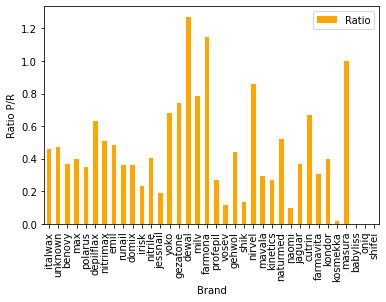

In [292]:
ax = cart_fin.plot.bar(y='Ratio', rot=0, color='orange')
plt.xlabel('Brand')
plt.ylabel('Ratio P/R')
plt.xticks(rotation=90)
plt.savefig("fig/Brand_Ratio")

### Graph 5

In [210]:
hour_count = ecom_df.groupby(["event_type"])["hour"].value_counts()
#({'purchase': 1, 'remove_from_cart': 0})

In [214]:
cart_p2 = hour_count[1]
cart_r2 = hour_count[0]
hour_fin = pd.concat([cart_p2, cart_r2], axis=1)
hour_fin.columns.values[0]="Purchase"
hour_fin.columns.values[1]="Removed"
hour_fin = cart_fin2.fillna(0.0)
hour_fin["Ratio"] = cart_fin2.Purchase/cart_fin2.Removed
hour_fin.sort_values(by="Ratio")

,Purchase,Removed,Ratio
hour,,,
3,163,539,0.302412
2,149,441,0.337868
5,430,1158,0.371330
18,924,2422,0.381503
22,394,989,0.398382
19,946,2347,0.403068
4,286,706,0.405099
16,902,2216,0.407040
17,919,2228,0.412478


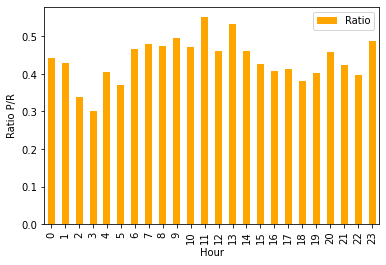

In [226]:
ax = hour_fin.plot.bar(y='Ratio', rot=0, color='orange')
plt.xlabel('Hour')
plt.ylabel('Ratio P/R')
plt.xticks(rotation=90)
plt.savefig("figs/Hour_Ratio")

### Graph ?

In [64]:
cart_count.plot.bar(figsize=(7, 5))
plt.legend(title='Value Counts', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.savefig("figs/Brand_Behaviour")

In [ ]:
sns.barplot(x='no_employees', y='Count', data=dft, hue='treatment')

In [41]:
plt.hist([bank[0], bank[1]], color=['r','b'], alpha=0.5)
plt.savefig("figs/Brand_Behaviour")

In [ ]:
df_gb = df.groupby(['year', 'month', 'class']).size().unstack(level=2)

### Graph 7

In [66]:
grp_by_hr_event_type = ecom_df.groupby(['hour','event_type']).count()

In [68]:
layout= dict(title="Hourly Store Traffic", xaxis_title="Time of Day", yaxis_title="Number of  Users")
grp_by_hr_event_type['user_id'].unstack(1).plot(kind="bar", layout=layout)
plt.savefig("test")

In [70]:
grp_by_brand_count = ecom_df.groupby(['brand','event_type']).count()

In [72]:
layout= dict(title="Hourly Store Traffic", xaxis_title="Time of Day", yaxis_title="Number of  Users")
grp_by_brand_count['user_id'].unstack(1).plot(kind="bar", layout=layout, figsize=(16,24))
plt.savefig("figs/test2")

# Pickle

In [42]:
# load the model from disk
loaded_model = pickle.load(open('best_model.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8096333957720097


### Time line graph

In [221]:
date = ecom_df.loc[:,['event_time','user_id']]
date['event_time'] = date['event_time'].apply(lambda d: str(d)[0:10])

In [222]:
visitor_by_date = date.groupby(['event_time'])['user_id'].nunique()
visitor_by_date

event_time
2019-10-01    164
2019-10-02    179
2019-10-03    142
2019-10-04    151
2019-10-05    129
             ... 
2020-02-25    224
2020-02-26    211
2020-02-27    170
2020-02-28    184
2020-02-29    163
Name: user_id, Length: 152, dtype: int64

<class 'pandas.core.series.Series'>


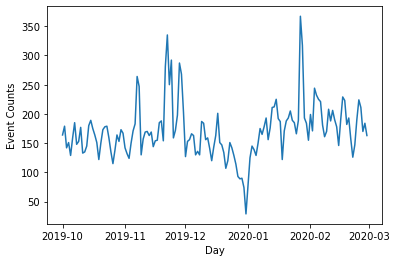

In [231]:
X = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date[:]

print(type(visitor_by_date))
plt.plot(X,y)
plt.xlabel('Day')
plt.ylabel('Event Counts')
plt.savefig('figs/Vistor_Line_Graph')

plt.show()

### Pie graph

In [232]:
ecom_df = pd.concat([oct19, nov19, dec19, jan20, feb20], axis=0)

In [236]:
df_pie = ecom_df["event_type"].value_counts()
df_pie

view                9657821
cart                5768333
remove_from_cart    3979679
purchase            1287007
Name: event_type, dtype: int64

In [240]:
df_pie = ecom_df["event_type"].value_counts().rename_axis('unique_values').to_frame('counts')

In [241]:
df_pie

,counts
unique_values,
view,9657821
cart,5768333
remove_from_cart,3979679
purchase,1287007


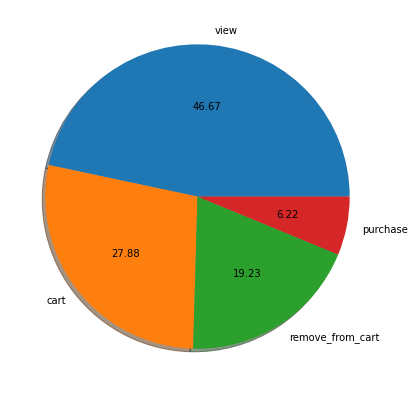

In [248]:
# Creating plot 
fig = plt.figure(figsize =(10, 7)) 
plt.pie(df_pie.counts, labels = df_pie.index, shadow=True, autopct='%.2f') 
  
# show plot 
plt.savefig("Event_type_pie")
plt.show() 